In [20]:
# 1. Train wider (1.45) model for mobilenet_v2, mnasnet and resnet18 without amda.
# 2. Pruning with [global_weight, random_channels, random_weight, l1_channels]
# 3. Make a plot with MACs and number of params vs ImageNet-C (also add baselines), networks (style) and pruning_method (color).
#    the rest should go into the appendix.
from utils import collect, to_percentage
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import yaml

from pruneshift.networks import create_network
from pruneshift.prune_info import PruneInfo
from pruneshift.utils import get_model_complexity_prune

path_pruning = Path("/work/dlclarge2/hoffmaja-pruneshift/experiments/img100/workshop/pruning/")
paths_scaled = [Path("/work/dlclarge2/hoffmaja-pruneshift/shashank_runs/icml_runs_new/mobilenet_v2/mobilenet_v2_scaled_2_std/"),
                Path("/work/dlclarge2/hoffmaja-pruneshift/shashank_runs/icml_runs_new/standard/resnet_18_std_scaled_2/"),
                Path("/work/dlclarge2/hoffmaja-pruneshift/shashank_runs/icml_runs_new/mnasnet/mnasnet_scaled_2_std/")]
path_baseline = Path("/work/dlclarge2/hoffmaja-pruneshift/experiments/img100/workshop/baselines/")

sns.set_context("talk")
sns.set_style("ticks")

In [3]:
df_prune = collect(path_pruning)
df_wider = collect(*paths_scaled)
df_baseline = collect(path_baseline).query("Scaling == 1")

In [9]:
# Add point zero.
entries = []
for (network, method), _ in df_prune.groupby(by=["Network", "Prune Method"]):
    entry = df_wider.query(f"Network == '{network}'").copy()
    entry[["Prune Method", "Prune Amount"]] = [method, 0.]
    entries.append(entry)

df_prune = df_prune.append(pd.concat(entries))

In [10]:
df_baseline

,Amda,Augmix,DeepAugment,ImageNet100 Error,ImageNet100-C Error,ImageNet100-R Error,Loss,Network,Path,Scaling
270,False,False,False,0.1138,0.531680,0.693740,StandardLoss,mnasnet1_0,/work/dlclarge2/hoffmaja-pruneshift/experiment...,1
270,False,False,False,0.1174,0.511125,0.686692,StandardLoss,resnet18,/work/dlclarge2/hoffmaja-pruneshift/experiment...,1
270,False,False,False,0.1176,0.543219,0.689020,StandardLoss,mobilenet_v2,/work/dlclarge2/hoffmaja-pruneshift/experiment...,1


In [17]:
def calculate_info(row):
    path = Path(row["Path"]) / "checkpoint/last.ckpt" 
    net = create_network("imagenet", row["Network"], 100, ckpt_path=path, scaling_factor=row["Scaling"])
    size = PruneInfo(net).network_size()
    macs, _ = get_model_complexity_prune(net, input_res=(3, 224, 224))
    return macs, size / 10e6

def add_info(df):
    df[["MACs", "Model Size"]] = df[["Path", "Scaling", "Network"]].apply(calculate_info, axis=1, result_type="expand")
    return df

In [18]:
add_info(df_prune)

,Amda,Augmix,DeepAugment,ImageNet100 Error,ImageNet100-C Error,ImageNet100-R Error,Loss,Network,Path,Prune Amount,Prune Method,Scaling,MACs,Model Size
270,False,False,False,0.1092,0.550019,0.690248,StandardLoss,mobilenet_v2,/work/dlclarge2/hoffmaja-pruneshift/experiment...,0.75,global_weight,1.45,2.760228e+08,0.119872
270,False,False,False,0.1070,0.499283,0.665222,StandardLoss,resnet18,/work/dlclarge2/hoffmaja-pruneshift/experiment...,0.50,l1_channels,1.45,1.945417e+09,1.175519
270,False,False,False,0.1132,0.530976,0.694452,StandardLoss,mnasnet,/work/dlclarge2/hoffmaja-pruneshift/experiment...,0.75,global_weight,1.45,2.693344e+08,0.157423
270,False,False,False,0.1012,0.479072,0.669814,StandardLoss,resnet18,/work/dlclarge2/hoffmaja-pruneshift/experiment...,0.25,random_weight,1.45,2.831812e+09,1.764106
270,False,False,False,0.1132,0.537000,0.689990,StandardLoss,mnasnet,/work/dlclarge2/hoffmaja-pruneshift/experiment...,0.25,random_channels,1.45,4.787096e+08,0.472335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,False,False,False,0.1080,0.522920,0.683070,StandardLoss,mobilenet_v2,/work/dlclarge2/hoffmaja-pruneshift/shashank_r...,0.00,random_weight,1.45,6.337236e+08,0.479488
270,False,False,False,0.1034,0.490579,0.677509,StandardLoss,resnet18,/work/dlclarge2/hoffmaja-pruneshift/shashank_r...,0.00,global_weight,1.45,3.721060e+09,2.352141
270,False,False,False,0.1034,0.490579,0.677509,StandardLoss,resnet18,/work/dlclarge2/hoffmaja-pruneshift/shashank_r...,0.00,l1_channels,1.45,3.721060e+09,2.352141
270,False,False,False,0.1034,0.490579,0.677509,StandardLoss,resnet18,/work/dlclarge2/hoffmaja-pruneshift/shashank_r...,0.00,random_channels,1.45,3.721060e+09,2.352141


In [19]:
add_info(df_baseline)

,Amda,Augmix,DeepAugment,ImageNet100 Error,ImageNet100-C Error,ImageNet100-R Error,Loss,Network,Path,Scaling,MACs,Model Size
270,False,False,False,0.1138,0.531680,0.693740,StandardLoss,mnasnet1_0,/work/dlclarge2/hoffmaja-pruneshift/experiment...,1,3.289753e+08,0.323041
270,False,False,False,0.1174,0.511125,0.686692,StandardLoss,resnet18,/work/dlclarge2/hoffmaja-pruneshift/experiment...,1,1.821716e+09,1.122781
270,False,False,False,0.1176,0.543219,0.689020,StandardLoss,mobilenet_v2,/work/dlclarge2/hoffmaja-pruneshift/experiment...,1,3.190844e+08,0.235197


In [21]:
to_percentage(df_prune)
to_percentage(df_baseline)

In [31]:
# To get consistent coloring we need to sort by values.
df_prune = df_prune.sort_values(by="Prune Method")

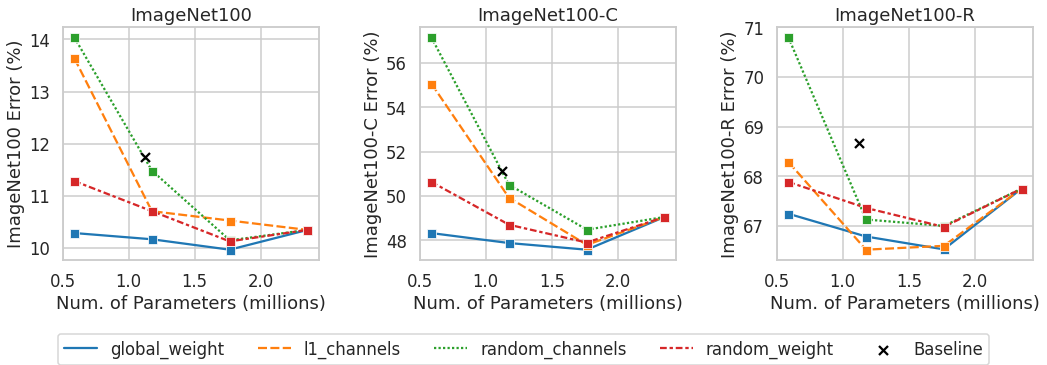

In [32]:
sns.set_style("whitegrid")
ERROR_LABELS = {"ImageNet100 Error": "ImageNet100", "ImageNet100-C Error": "ImageNet100-C", "ImageNet100-R Error": "ImageNet100-R"}
fig, axes = plt.subplots(1, 3, figsize=(15.5, 5.5))
df_part = df_prune.query("Network == 'resnet18'")

for (error, label), ax in zip(ERROR_LABELS.items(), axes.flatten()):
    sns.lineplot(data=df_part, x="Model Size", y=error , hue="Prune Method", ax=ax, marker="s", style="Prune Method")
    y, x = df_baseline.query("Network == 'resnet18'")[[error, "Model Size"]].to_numpy()[0]
    # ax.plot(x, y, color="grey", marker=True, )
    ax.scatter(x, y, marker='x', color='black', label='Baseline', zorder=19)
    plt.tight_layout()
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend('', frameon=False)
    ax.set_title(label)
    ax.set_ylabel(error + " (%)" )
    ax.set_xlabel("Num. of Parameters (millions)")

fig.tight_layout(pad=2.5)
fig.legend(handles, labels, loc="lower center", borderaxespad=0., ncol=5)
plt.savefig("figures/pruning_main_plot.pdf")

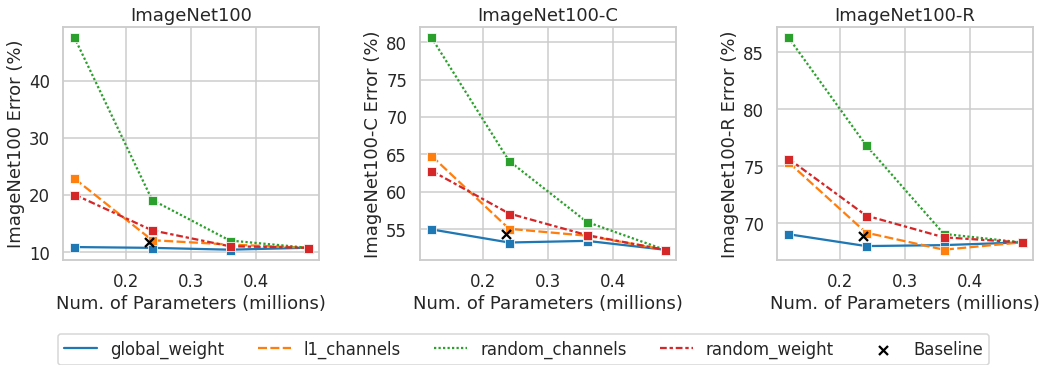

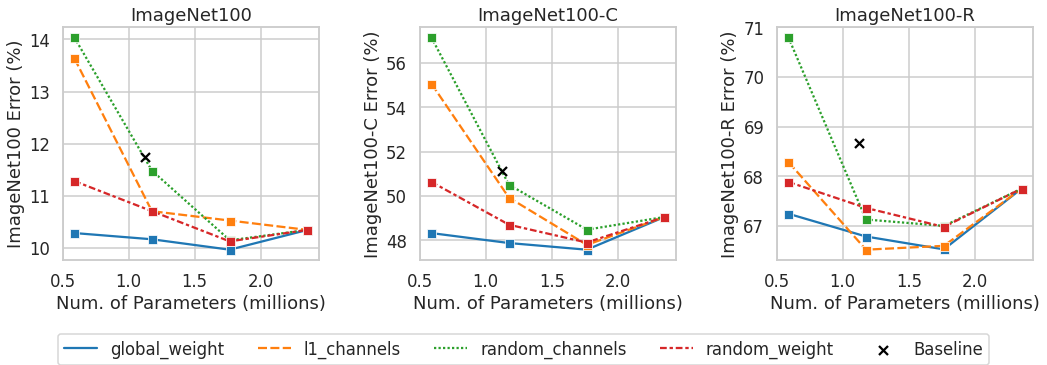

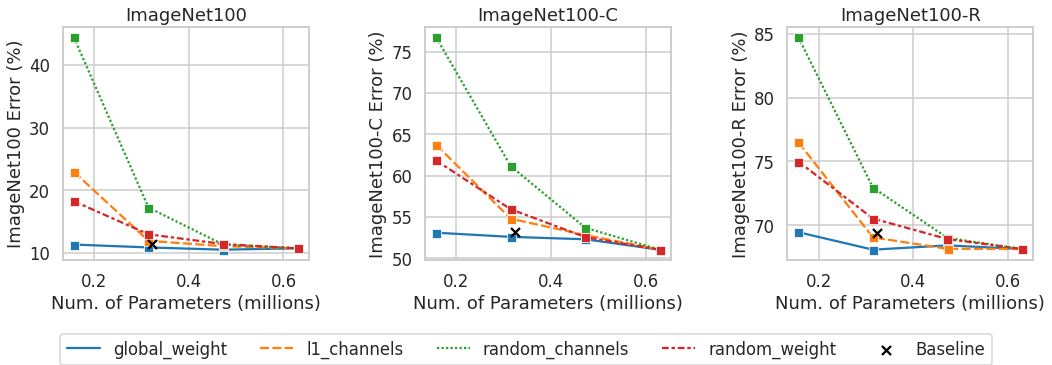

In [33]:
sns.set_style("whitegrid")
ERROR_LABELS = {"ImageNet100 Error": "ImageNet100", "ImageNet100-C Error": "ImageNet100-C", "ImageNet100-R Error": "ImageNet100-R"}

for network in df_prune["Network"].unique():
    fig, axes = plt.subplots(1, 3, figsize=(15.5, 5.5))
    df_part = df_prune.query(f"Network == '{network}'")

    for (error, label), ax in zip(ERROR_LABELS.items(), axes.flatten()):
        sns.lineplot(data=df_part, x="Model Size", y=error , hue="Prune Method", ax=ax, marker="s", style="Prune Method")
        if network == "mnasnet":
            network = "mnasnet1_0"

        y, x = df_baseline.query(f"Network == '{network}'")[[error, "Model Size"]].to_numpy()[0]

        ax.scatter(x, y, marker='x', color='black', label='Baseline', zorder=19)
        plt.tight_layout()

        handles, labels = ax.get_legend_handles_labels()
        ax.legend('', frameon=False)
        ax.set_title(label)
        ax.set_ylabel(error + " (%)" )
        ax.set_xlabel("Num. of Parameters (millions)")

    fig.tight_layout(pad=2.5)
    fig.legend(handles, labels, loc="lower center", borderaxespad=0., ncol=5)
    plt.savefig(f"figures/pruning_suppl_plot_{network}.pdf")

<AxesSubplot:xlabel='Model Size', ylabel='ImageNet100-C Error'>

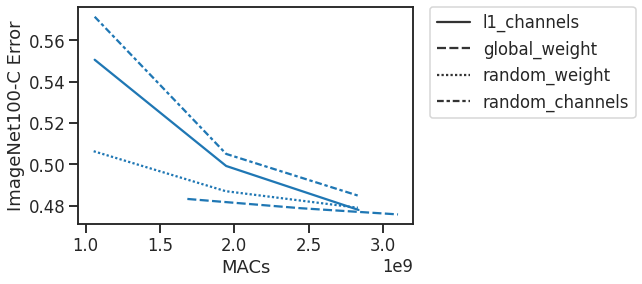

In [191]:
g = sns.lineplot(data=df_prune.query("Network == 'resnet18'"), x="MACs", y="ImageNet100-C Error", style="Prune Method")
g.axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

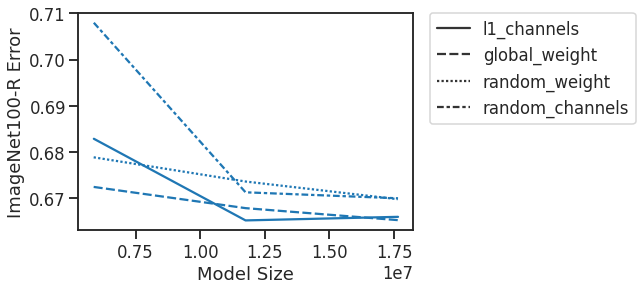

In [192]:
g = sns.lineplot(data=df_prune.query("Network == 'resnet18'"), x="Model Size", y="ImageNet100-R Error", style="Prune Method")
g.axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

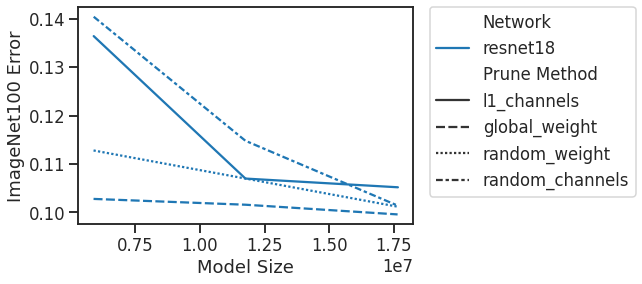

In [189]:
g = sns.lineplot(data=df_prune.query("Network == 'resnet18'"), x="Model Size", y="ImageNet100 Error", hue="Network", style="Prune Method")
g.axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [54]:
df = collect(path)
df_baseline = collect(path_baseline).query("Scaling == 1")
df_scaled = collect(scaled_path).query("Augmix == False").append(df_baseline.query("Network == 'resnet18'"))
df_kd = collect(path_kd)

In [55]:
df_scaled

,Amda,Augmix,DeepAugment,ImageNet100 Error,ImageNet100-C Error,ImageNet100-R Error,Loss,Network,Path,Scaling
270,False,False,False,0.1004,0.473624,0.665804,StandardLoss,resnet18,/work/dlclarge2/hoffmaja-pruneshift/experiment...,2.0
270,False,False,False,0.0928,0.469701,0.666839,StandardLoss,resnet18,/work/dlclarge2/hoffmaja-pruneshift/experiment...,2.5
270,False,False,False,0.1004,0.460717,0.668973,StandardLoss,resnet18,/work/dlclarge2/hoffmaja-pruneshift/experiment...,3.0
270,False,False,False,0.0934,0.455067,0.665869,StandardLoss,resnet18,/work/dlclarge2/hoffmaja-pruneshift/experiment...,3.5
270,False,False,False,0.0946,0.458963,0.671883,StandardLoss,resnet18,/work/dlclarge2/hoffmaja-pruneshift/experiment...,4.0
270,False,False,False,0.1174,0.511125,0.686692,StandardLoss,resnet18,/work/dlclarge2/hoffmaja-pruneshift/experiment...,1.0


In [56]:
df_scaled_ = pd.melt(df_scaled, id_vars=["Scaling"], value_vars=["ImageNet100 Error", "ImageNet100-C Error", "ImageNet100-R Error"], var_name="Error Type", value_name="Error")

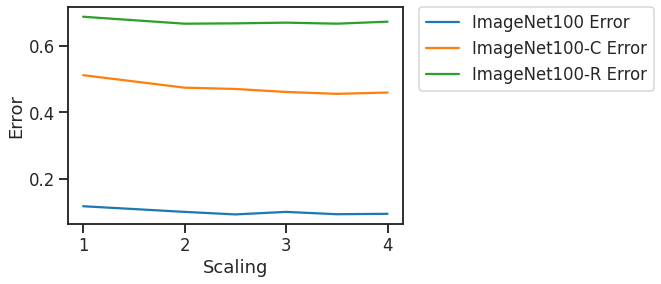

In [57]:
sns.lineplot(data=df_scaled_, x="Scaling", y="Error", hue="Error Type")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [58]:
df_mnas = df.query("Network == 'mnasnet'") # .append(df_baseline.query("Network == 'mnasnet1_0'"))